# 🪄 yolo/prediction

In [1]:
from ultralytics import YOLO
from collections import Counter

from bluer_options import string
from bluer_objects import file
from bluer_objects import storage
from bluer_objects.metadata import post_to_object
from bluer_objects import objects
from bluer_sandbox import notebooks
from bluer_objects.graphics.signature import add_signature

from bluer_algo.host import signature
from bluer_algo.yolo.dataset.classes import YoloDataset
from bluer_algo import env
from bluer_algo.logger import logger

logger.info(f"{'.'.join(signature())},\nbuilt on {string.pretty_date()}")

🪄  bluer_algo-4.388.1.bluer_ai-12.259.1.bluer_objects-6.258.1.bluer_options-5.164.1.torch-2.2.2.Python 3.12.9.Darwin 23.6.0..Jupyter-Notebook,
built on 15 September 2025, 13:05:35


In [2]:
verbose = True
line_width: int = 80

In [3]:
prediction_object_name = objects.unique_object("yolo-prediction")

🌀  📂 yolo-prediction-2025-09-15-13-05-35-m1cgn2


---

In [4]:
dataset_object_name = env.BLUER_ALGO_COCO128_TEST_DATASET
# assert storage.download(dataset_object_name)

In [5]:
dataset = YoloDataset(object_name=dataset_object_name)
assert dataset.valid

🪄  found 128 image(s).
🪄  found 128 label(s).
🪄  missing 2 image(s): 000000000508, 000000000250
🪄  missing 2 label(s): 000000000659, 000000000656
🪄  YoloDataset, 126 record(s),  80 class(es): person, bicycle, car, motorcycle, airplane, ...


---

In [6]:
model_object_name = env.BLUER_ALGO_COCO128_TEST_MODEL
# assert storage.download(model_object_name)

In [7]:
model_filename = objects.path_of(
    object_name=model_object_name,
    filename="train/weights/best.pt",
)

model = YOLO(model_filename)

---

In [8]:
record_id = dataset.list_of_records[0]

success, image = dataset.load_image(
    record_id=record_id,
    verbose=True,
    )
assert success

🌀  loaded 480x640x3:uint8 from /Users/kamangir/storage/abcli/coco128-2025-09-14-q6oxj4/coco128/images/train2017/000000000612.jpg


In [9]:
results = model.predict(source=image)

if len(results) != 1:
    logger.warning(f"expected 1 result, received {len(results)}.")

if verbose:
    logger.info(results)

/Users/kamangir/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0: 480x640 1 person, 144.1ms
Speed: 2.6ms preprocess, 144.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.
🪄  [ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'person'}
obb: None
orig_img: array([[[105, 100, 107],
        [103,  98, 105],
        [102,  99, 106],
        ...,
        [128, 132,  82],
        [122, 122,  72],
        [173, 173, 123]],

       [[105, 100, 107],
        [104,  99, 106],
        [103, 100, 107],
        ...,
        [129, 131,  82],
        [141, 141,  91],
        [127, 127,  77]],

       [[106, 101, 108],
        [105, 100, 107],
        [103, 100, 107],
        ...,
        [176, 175, 127],
        [139, 139,  89],
        [173, 171, 122]],

       ...,

       [[ 21,   2,   4],
        [ 21,   2,   4],
        [ 21,   2,   4],
        ...,
        [152, 125, 108],
        [139, 106,  87],
        [141, 106,  86]],

       [[ 22,   2,   4],
        [ 22,   2,   4],
        [ 22,   2,  

In [10]:
detection = results[0]

In [11]:
detections_as_str = " + ".join([f"{count} x {class_name}" for class_name, count in dict(Counter([dataset.metadata["names"][int(box.cls)] for box in detection.boxes])).items()])
detections_as_str = f"{len(detection.boxes)} detection(s): {detections_as_str}"
logger.info(detections_as_str)

🪄  1 detection(s): 1 x person


In [12]:
if verbose:
    annotated_image = add_signature(
        detection.plot(),
        header=[
            " | ".join(
                ["yolo"]
                + objects.signature(
                    record_id,
                    object_name=dataset_object_name,
                )
                + [
                    f"model: {model_object_name}",
                    f"{len(detection.boxes)} detection(s)",
                    detections_as_str,
                ]
            )
        ],
        footer=[" | ".join(signature())],
        line_width=line_width,
    )

    assert file.save_image(
        objects.path_of(
                object_name=prediction_object_name,
                filename=f"{record_id}.png"
        ),
        annotated_image,
        log=verbose,
    )


🌀  bluer_objects.file.save.save_image: 584x640x3:uint8 -> /Users/kamangir/storage/abcli/yolo-prediction-2025-09-15-13-05-35-m1cgn2/000000000612.png


""

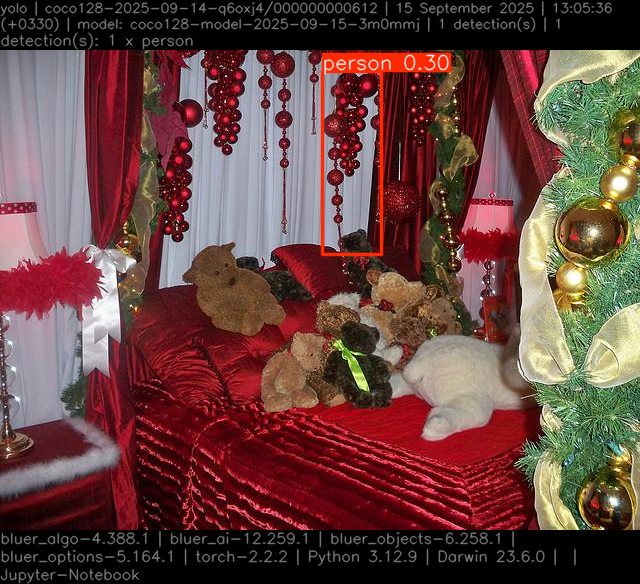

In [13]:
notebooks.imshow(objects.path_of(
    object_name=prediction_object_name,
    filename=f"{record_id}.png"
))

In [14]:
if verbose:
    detections = []
    for box in detection.boxes:
        class_id = int(box.cls[0])
        detections.append({
            "class_id": class_id,
            "label": model.names[class_id],
            "confidence": float(box.conf[0]),
            "bbox_xyxy": box.xyxy[0].cpu().numpy().tolist()  # [x1, y1, x2, y2]
        })

    # wrap in a dict for saving
    metadata = {
        "detections": detections,
        "image_size": list(detection.orig_shape),   # (H, W)
    }

    assert post_to_object(
        prediction_object_name,
        record_id,
        metadata
    )

🌀  bluer_objects.metadata.post.post[/Users/kamangir/storage/abcli/yolo-prediction-2025-09-15-13-05-35-m1cgn2/metadata.yaml]: 000000000612
🌀  bluer_objects.file.save.save_yaml: 000000000612 -> /Users/kamangir/storage/abcli/yolo-prediction-2025-09-15-13-05-35-m1cgn2/metadata.yaml.


---

In [15]:
assert notebooks.upload(prediction_object_name)

100%|██████████| 3/3 [00:02<00:00,  1.06it/s]
🌀  ⏺️  yolo-prediction-2025-09-15-13-05-35-m1cgn2 | 00001
🌀  ⬆️  /Users/kamangir/storage/abcli/yolo-prediction-2025-09-15-13-05-35-m1cgn2/000000000612.png
🌀  ⬆️  /Users/kamangir/storage/abcli/yolo-prediction-2025-09-15-13-05-35-m1cgn2/metadata.yaml
🌀  ⏹️  yolo-prediction-2025-09-15-13-05-35-m1cgn2


In [16]:
# END